# OSMnx overview: querying, simplifying, visualizing, saving

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  
Once you've perused the [features demo notebook](00-osmnx-features-demo.ipynb), this notebook demonstrates more details on querying for place boundaries and street networks, visualizing, and saving models to disk.

In [1]:
import geopandas
geopandas.show_versions()


SYSTEM INFO
-----------
python     : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
executable : C:\Users\psle1\anaconda3\python.exe
machine    : Windows-10-10.0.22000-SP0

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.0.2
GDAL data dir: None
PROJ       : 8.2.1
PROJ data dir: C:\Users\psle1\anaconda3\lib\site-packages\pyproj\proj_dir\share\proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.12.1
numpy      : 1.23.3
pandas     : 1.5.0
pyproj     : 3.3.1
shapely    : 1.8.2
fiona      : 1.8.13
geoalchemy2: None
geopy      : 2.2.0
matplotlib : 3.6.2
mapclassify: 2.4.3
pygeos     : None
pyogrio    : None
psycopg2   : None
pyarrow    : None
rtree      : 1.0.1


In [1]:
import geopandas as gpd
import osmnx as ox

%matplotlib inline
ox.__version__

'1.2.2'

You can configure OSMnx using the `settings` module. See the [documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.settings) for the settings you can configure. For example, by default OSMnx caches all server responses to prevent repeatedly hitting the server for the same query every time you run it. This both makes our code faster on subsequent runs and helps us be a "good neighbor" to the server. But you can turn caching off (or back on again) with the `use_cache` setting.

In [ ]:
# turn response caching off
ox.settings.use_cache = False

# turn it back on and turn on/off logging to your console
ox.settings.use_cache = True
ox.settings.log_console = False

## Part 1: get place boundaries from OpenStreetMap

OSMnx lets you download place boundary geometries from OpenStreetMap, project them, and plot them. For a more in-depth demonstration of querying by place, see [this notebook](03-graph-place-queries.ipynb).

In [2]:
import pyproj

pyproj.datadir.get_data_dir()

'C:\\Users\\psle1\\anaconda3\\lib\\site-packages\\pyproj\\proj_dir\\share\\proj'

NameError: name 'pyproj' is not defined

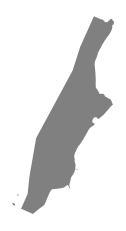

In [3]:



# get the boundary polygon for manhattan, project it, and plot it
city = ox.geocode_to_gdf("Manhattan, New York, USA")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")

In [7]:
import pyproj
pyproj.datadir.set_data_dir('C:\\Users\\psle1\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj')
pyproj.datadir.get_data_dir()

'C:\\Users\\psle1\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj'

In [ ]:
from pyproj import CRS


In [4]:
# get boundary polygons for several cities, save as GeoPackage, project to UTM, and plot
place_names = [
    "Berkeley, California, USA",
    "Oakland, California, USA",
    "Piedmont, California, USA",
    "Emeryville, California, USA",
    "Alameda, Alameda County, CA, USA",
]

east_bay = ox.geocode_to_gdf(place_names)
east_bay.to_file("./data/east_bay.gpkg", driver="GPKG")
east_bay = ox.project_gdf(east_bay)
ax = east_bay.plot(fc="gray", ec="none")
_ = ax.axis("off")

CRSError: Invalid input to create CRS: GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4326]]

In [ ]:
# if you know the OSM ID of the place(s) you want, you can query it directly
ox.geocode_to_gdf(["R357794", "N8170768521", "W427818536"], by_osmid=True)

## Part 2: download and model street networks

OSMnx lets you download street network data and build topologically-corrected street networks, project and plot the networks, and save the street network as SVGs, GraphML files, GeoPackages, or shapefiles for later use. The street networks are directed and preserve one-way directionality. For a more in-depth demonstration of creating street networks, see [this notebook](03-graph-place-queries.ipynb).

You can download a street network by providing OSMnx any of the following (demonstrated in the examples below):
  - a bounding box
  - a lat-long point plus a distance
  - an address plus a distance
  - a place name or list of place names (to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries
  - a .osm formatted xml file

You can also specify several different network types:
  - 'drive' - get drivable public streets (but not service roads)
  - 'drive_service' - get drivable streets, including service roads
  - 'walk' - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
  - 'bike' - get all streets and paths that cyclists can use
  - 'all' - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
  - 'all_private' - download all OSM streets and paths, including private-access ones

 #### Method #1, pass a bounding box ####
 This constructs the network from all the OSM nodes and ways within the bounding box.

In [5]:
# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43

# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")

#### Method #2, pass a lat-lng point and bounding box distance in meters
This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box.

In [46]:
# define a point at the corner of California St and Mason St in SF
location_point = (41.74, -122.410018)

# create network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph_from_point(location_point, dist=750, dist_type="bbox", network_type="drive")

NetworkXPointlessConcept: Connectivity is undefined for the null graph.

#### Method #3, pass a lat-lng point and *network* distance in meters ####

This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. Then it truncates the network by removing all nodes further than *n* meters from the point along the network.

In [57]:
data = pd.read_csv('low_income_tracts_centroid.csv')

data_sample = data.sample(15, random_state=42)
data_sample

,latitudes,longitudes,med_income,tract_name
840,36.451818,-119.446882,31635.0,"Census Tract 3.02, Tulare County, California"
834,36.135445,-119.441694,35000.0,"Census Tract 31, Tulare County, California"
1163,33.816539,-118.218280,24153.0,"Census Tract 5725, Los Angeles County, California"
789,36.345949,-121.453012,40278.0,"Census Tract 111.01, Monterey County, California"
1624,33.784877,-118.278290,49882.0,"Census Tract 2943.02, Los Angeles County, Cali..."
321,38.573473,-121.319084,36930.0,"Census Tract 90.06, Sacramento County, California"
1196,33.974189,-118.361782,40590.0,"Census Tract 6013.03, Los Angeles County, Cali..."
495,37.736498,-120.932463,36577.0,"Census Tract 3.01, Stanislaus County, California"
507,37.771041,-122.206748,49722.0,"Census Tract 4074, Alameda County, California"
1061,34.938302,-119.150691,48250.0,"Census Tract 33.06, Kern County, California"


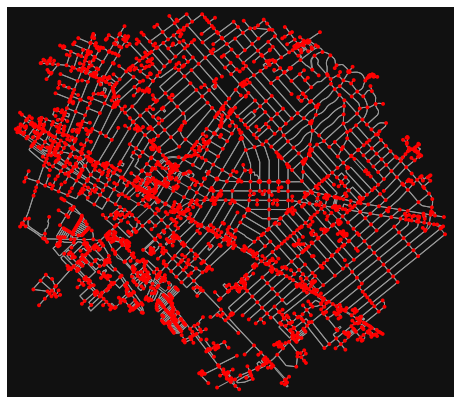

In [60]:
# same point again, but create network only of nodes within 500m along the network from point
location_point = (37.771041, -122.206748)

G = ox.graph_from_point(location_point, dist=2500, dist_type="network", network_type="bike")
fig, ax = ox.plot_graph(G, node_color="r")

*Note* the plot above shows the network within 500m (traveling distance along the network) from the `location_point`. By default, the `network_type` parameter value is 'all', meaning that we do not filter out paths that restrict certain types of traffic. This also means that one-way streets are honored as one-way and you cannot travel the wrong direction down them. Thus, the 500m takes into account only those nodes you can reach within 500m while only traveling in the allowed direction of the street. Instead (below), we can specify `network_type='walk'` to build a street network only of paths that walking is allowed on. This also makes every path bi-directional in the directed network, because you can walk in either direction on the sidewalk of a one-way street. Thus, the 500m now takes into account those nodes you can reach within 500m while traveling in either direction (even if it's a one-way street).

#### Method #4, pass an address and distance (*bounding box* or *network*) in meters ####
This geocodes the address, creates a bounding box, downloads the network, then truncates it by network distance (if distance_type='network').

In [ ]:
# network from address, including only nodes within 1km along the network from the address
G = ox.graph_from_address(
    address="350 5th Ave, New York, NY",
    dist=1000,
    dist_type="network",
    network_type="drive",
)

# you can project the network to UTM (zone calculated automatically)
G_projected = ox.project_graph(G)

#### Method #5, pass a place name ####

This geocodes the place name, gets the place's boundary shape polygon and bounding box, downloads the network within the bounding box, then truncates it to the place's boundary polygon.

In [ ]:
# create the street network within the city of Piedmont's borders
G = ox.graph_from_place("Piedmont, California, USA", network_type="drive")

In [ ]:
# you can also pass multiple places as a mixed list of strings and/or dicts
places = [
    "Los Altos, California, USA",
    {"city": "Los Altos Hills", "state": "California"},
    "Loyola, California",
]
G = ox.graph_from_place(places, truncate_by_edge=True)

In [ ]:
# save to disk as GeoPackage file then plot
ox.save_graph_geopackage(G)
fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

#### Method #6, pass a polygon ####

This example loads the [Mission District](http://www.zillow.com/howto/api/neighborhood-boundaries.htm)'s polygon from a shapefile, then downloads the network within its bounding box, then prunes all nodes that lie outside the place's boundary polygon.

In [24]:
import geopandas as gpd
import osmnx as ox
calif = gpd.read_file("low_income_tracts/")


In [5]:
# Get CRS for DC shapefile
print("CRS: {}".format(calif.crs))

CRS: epsg:4269


In [32]:
import censusgeocode as cg

In [35]:
cg.onelineaddress('Census Tract 1.04, Del Norte County, California')

[]

In [41]:
shape = calif['geometry'][0]
for coords in shape:
    print(coords)

TypeError: 'Polygon' object is not iterable

In [9]:
calif = gpd.read_file("low_income_tracts/low_income_tracts.shp")
calif = calif.to_crs("EPSG:4326")


In [11]:
calif.plot()

ValueError: 'box_aspect' and 'fig_aspect' must be positive

Error in callback <function _draw_all_if_interactive at 0x0000024C7A909DC0> (for post_execute):


ValueError: 'box_aspect' and 'fig_aspect' must be positive

ValueError: 'box_aspect' and 'fig_aspect' must be positive

<Figure size 432x288 with 1 Axes>

In [27]:
calif = gpd.read_file("low_income_tracts/low_income_tracts.shp")
# mission_district = calif[(calif["CITY"] == "San Francisco") & (calif["NAME"] == "Mission")]
polygon = calif["geometry"].iloc[0]

G2 = ox.graph_from_polygon(polygon, network_type="drive_service")

CRSError: Invalid projection: +proj=utm +zone=-2304161 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1027 (Invalid value for an argument): utm: Invalid value for zone)

In [17]:
import pandas as pd
import censusdata
from tabulate import tabulate

#### Method #7, load a .osm xml file

In [28]:
# create graph from .osm extract file
G = ox.graph_from_xml("./input_data/West-Oakland.osm.bz2")

## Part 3: simplifying street network topology

Simplification is normally done by OSMnx automatically under the hood, but we can break it out to see how it works. OpenStreetMap nodes are weird. They include intersections, but they also include all the points along a single block where the street curves. The latter are not nodes in the graph theory sense, so we remove them algorithmically and consolidate the set of edges between "true" network nodes into a single edge. There are two simplification modes, strict and non-strict. The main difference is that unlike strict mode, non-strict mode allows simplification to an "expansion graph" (ie, if the graph were undirected, nodes with degree 2 as long as the incident edges have different OSM IDs). For a more in-depth demonstration of topological simplification with OSMnx, see [this notebook](04-simplify-graph-consolidate-nodes.ipynb).

In [ ]:
# create a network around some (lat, lng) point but do not simplify it yet
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, network_type="drive_service", dist=500, simplify=False)

In [ ]:
# turn off strict mode and see what nodes we'd remove, in yellow
nc = ["r" if ox.simplification._is_endpoint(G, node) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

The dots above are OSM nodes. We'll remove the nodes in yellow as they're not real network nodes (intersections/dead-ends).

In [ ]:
# simplify the network
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, node_color="r")

In [ ]:
# show the simplified network with edges colored by length
ec = ox.plot.get_edge_colors_by_attr(G, attr="length", cmap="plasma_r")
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

In [ ]:
# highlight all parallel (multiple) edges
ec = ["gray" if k == 0 or u == v else "r" for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

In [ ]:
# highlight all one-way edges in the mission district network from earlier
ec = ["r" if data["oneway"] else "w" for u, v, key, data in G2.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G2, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7)

## Part 4: saving networks to disk

For more examples of saving and loading networks to/from disk, see [this notebook](05-save-load-networks.ipynb).

In [ ]:
# save street network as GeoPackage to work with in GIS
ox.save_graph_geopackage(G, filepath="./data/network.gpkg")

In [ ]:
# save street network as GraphML file to work with later in OSMnx or networkx or gephi
ox.save_graphml(G, filepath="./data/network.graphml")

## Part 5: calculate basic network indicators

In [ ]:
# calculate basic street network metrics and display average circuity
stats = ox.basic_stats(G)
stats["circuity_avg"]

In this street network, the streets are ~16% more circuitous than the straight-lines paths would be.

For examples of analyzing street networks, see [this example](06-stats-indicators-centrality.ipynb).